In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 3)
plt.rcParams['font.family'] = 'sans-serif'

# Summary

By the end of this chapter, we're going to have downloaded all of Canada's weather data for 2012, and saved it to a CSV. 

We'll do this by downloading it one month at a time, and then combining all the months together.

Here's the temperature every hour for 2012!

<AxesSubplot:xlabel='Date/Time'>

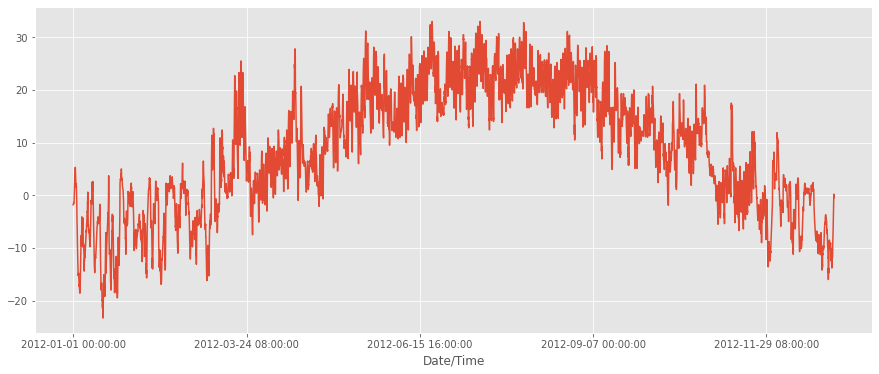

In [2]:
weather_2012_final = pd.read_csv('../data/weather_2012.csv', index_col='Date/Time')
weather_2012_final['Temp (C)'].plot(figsize=(15, 6))

# 5.1 Downloading one month of weather data

When playing with the cycling data, I wanted temperature and precipitation data to find out if people like biking when it's raining. So I went to the site for [Canadian historical weather data](http://climate.weather.gc.ca/index_e.html#access), and figured out how to get it automatically.

Here we're going to get the data for March 2012, and clean it up

Here's an URL template you can use to get data in Montreal. 

In [3]:
url_template = "http://climate.weather.gc.ca/climateData/bulkdata_e.html?format=csv&stationID=5415&Year={year}&Month={month}&timeframe=1&submit=Download+Data"

To get the data for March 2013, we need to format it with `month=3, year=2012`.

In [4]:
#url = url_template.format(month=3, year=2012)
#weather_mar2012 = pd.read_csv(url, skiprows=15, index_col='Date/Time', parse_dates=True, encoding='latin1', header=True)

# because the url is broken, we use our saved dataframe for now
weather_mar2012 = pd.read_csv('../data/weather_2012.csv')

This is super great! We can just use the same `read_csv` function as before, and just give it a URL as a filename. Awesome.

There are 16 rows of metadata at the top of this CSV, but pandas knows CSVs are weird, so there's a `skiprows` options. We parse the dates again, and set 'Date/Time' to be the index column. Here's the resulting dataframe.

In [5]:
weather_mar2012

Date/Time  Temp (C)  Dew Point Temp (C)  Rel Hum (%)  \
0     2012-01-01 00:00:00      -1.8                -3.9           86   
1     2012-01-01 01:00:00      -1.8                -3.7           87   
2     2012-01-01 02:00:00      -1.8                -3.4           89   
3     2012-01-01 03:00:00      -1.5                -3.2           88   
4     2012-01-01 04:00:00      -1.5                -3.3           88   
...                   ...       ...                 ...          ...   
8779  2012-12-31 19:00:00       0.1                -2.7           81   
8780  2012-12-31 20:00:00       0.2                -2.4           83   
8781  2012-12-31 21:00:00      -0.5                -1.5           93   
8782  2012-12-31 22:00:00      -0.2                -1.8           89   
8783  2012-12-31 23:00:00       0.0                -2.1           86   

      Wind Spd (km/h)  Visibility (km)  Stn Press (kPa)               Weather  
0                   4              8.0           101.24                   Fog  
1                   4              8.0           101.24                   Fog  
2                   7              4.0           101.26  Freezing Drizzle,Fog  
3                   6              4.0           101.27  Freezing Drizzle,Fog  
4                   7              4.8           101.23                   Fog  
...               ...              ...              ...                   ...  
8779               30              9.7           100.13                  Snow  
8780               24              9.7           100.03                  Snow  
8781               28              4.8            99.95                  Snow  
8782               28              9.7            99.91                  Snow  
8783               30             11.3            99.89                  Snow  

[8784 rows x 8 columns]

Let's plot it!

<AxesSubplot:>

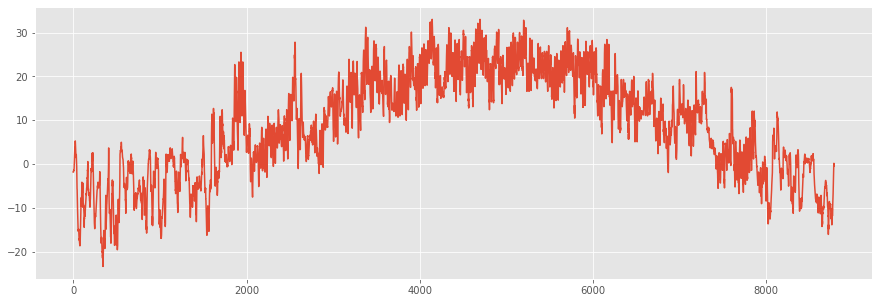

In [6]:
weather_mar2012[u"Temp (C)"].plot(figsize=(15, 5))

Notice how it goes up to 25° C in the middle there? That was a big deal. It was March, and people were wearing shorts outside. 

And I was out of town and I missed it. Still sad, humans.


You'll notice in the summary above that there are a few columns which are are either entirely empty or only have a few values in them. Let's get rid of all of those with `dropna`.

The argument `axis=1` to `dropna` means "drop columns", not rows", and `how='any'` means "drop the column if any value is null". 

This is much better now -- we only have columns with real data.

In [ ]:
weather_mar2012 = weather_mar2012.dropna(axis=1, how='any')
weather_mar2012[:5]

The Year/Month/Day/Time columns are redundant, though, and the Data Quality column doesn't look too useful. Let's get rid of those.

The `axis=1` argument means "Drop columns", like before. The default for operations like `dropna` and `drop` is always to operate on rows.

In [ ]:
weather_mar2012 = weather_mar2012.drop(['Year', 'Month', 'Day', 'Time', 'Data Quality'], axis=1)
weather_mar2012[:5]

Awesome! We now only have the relevant columns, and it's much more manageable.

# 5.2 Plotting the temperature by hour of day

This one's just for fun -- we've already done this before, using groupby and aggregate! We will learn whether or not it gets colder at night. Well, obviously. But let's do it anyway.

In [ ]:
temperatures = weather_mar2012[[u'Temp (C)']].copy()
print(temperatures.head)
temperatures.loc[:,'Hour'] = weather_mar2012.index.hour
temperatures.groupby('Hour').aggregate(np.median).plot()

So it looks like the time with the highest median temperature is 2pm. Neat.

# 5.3 Getting the whole year of data

Okay, so what if we want the data for the whole year? Ideally the API would just let us download that, but I couldn't figure out a way to do that.

First, let's put our work from above into a function that gets the weather for a given month. 

I noticed that there's an irritating bug where when I ask for January, it gives me data for the previous year, so we'll fix that too. [no, really. You can check =)]

In [ ]:
def download_weather_month(year, month):
    if month == 1:
        year += 1
    url = url_template.format(year=year, month=month)
    weather_data = pd.read_csv(url, skiprows=15, index_col='Date/Time', parse_dates=True, header=True)
    weather_data = weather_data.dropna(axis=1)
    weather_data.columns = [col.replace('\xb0', '') for col in weather_data.columns]
    weather_data = weather_data.drop(['Year', 'Day', 'Month', 'Time', 'Data Quality'], axis=1)
    return weather_data

We can test that this function does the right thing:

In [ ]:
download_weather_month(2012, 1)[:5]

Now we can get all the months at once. This will take a little while to run.

In [ ]:
data_by_month = [download_weather_month(2012, i) for i in range(1, 13)]

Once we have this, it's easy to concatenate all the dataframes together into one big dataframe using `pd.concat`. And now we have the whole year's data!

In [ ]:
weather_2012 = pd.concat(data_by_month)
weather_2012

# 5.4 Saving to a CSV

It's slow and unnecessary to download the data every time, so let's save our dataframe for later use!

In [ ]:
weather_2012.to_csv('../data/weather_2012.csv')

And we're done!